In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
%matplotlib inline

import sklearn
from sklearn.datasets import fetch_california_housing

plt.rcParams['font.size'] = 14

In [2]:
# Download data

tmp = sio.loadmat('HW2_q3_Boosting_data.mat', squeeze_me=True)

num_samples   = tmp['data'].shape[0]
feature_names = tmp['feature_names']
y = tmp['target']
X = tmp['data']

data = {}
for n, feature in enumerate(feature_names):
    data[feature] = tmp['data'][:,n]
    

In [3]:
def create_stump(data):

    # Create stumps

    # bin the data by proportion, 10% in each bin
    bins = {}
    bin_idx = (np.arange(0,1.1,0.1)*num_samples).astype(np.int16)
    bin_idx[-1] = bin_idx[-1]-1
    for feature in (feature_names):
        bins[feature] = np.sort(data[feature])[bin_idx]


# decision stumps as weak classifiers
# 0 if not in bin, 1 if in bin
    stumps = {}
    for feature in feature_names:
        stumps[feature] = np.zeros([num_samples,len(bins[feature])-1])
        for n in range(len(bins[feature])-1):
            stumps[feature][:,n] = data[feature]>bins[feature][n]


# stack the weak classifiers into a matrix
    H = np.hstack([stumps[feature] for feature in feature_names])
    H = np.hstack([np.ones([num_samples,1]),H])
# prepare the vector for storing weights

    return stumps, H, bins

### AdaBoost

In [4]:
num_iterations = 30
 # track mean square error

In [5]:
def direction(H, res):
    ret= np.zeros(H.shape[1])
    for j in range(H.shape[1]):
        for i in range(H.shape[0]):
            r= res[i]
            weight= H[i][j]
            ret[j]+= r*weight
        ret[j]=np.absolute(ret[j])
            
    return np.argmax(ret)
            

In [6]:
def move(H, res, maxj):
    sum1=0
    sum2=0
    for i in range(H.shape[0]):
        sum1+=res[i]*H[i][maxj]
        sum2+=H[i][maxj]**2
    
    return sum1/sum2

In [7]:
def adaboost(data):
    global y
    stumps, H, bins= create_stump(data)
    alphas = np.zeros(81)
    MSE = np.zeros(num_iterations)
    for iteration in range(num_iterations):
        f = H.dot(alphas)
        r = y-f; MSE[iteration] = np.mean(r**2) # r = residual
        idx = direction(H, r)
        alphas[idx] = alphas[idx] + move(H, r, idx)
    
    return alphas, stumps, MSE, bins

In [8]:
#adaboost for unscrambled data

alphas, stumps, MSE_normal, bins = adaboost(data)

print(MSE_normal[-1])

0.49531801301559214


### Variable importance

In [9]:
importance={}

for feature in feature_names:
    data_shuffle= data.copy()
    data_shuffle[feature]=np.random.permutation(data_shuffle[feature])
    alpha_feat, stump_feat, MSE_feat, bins_feat= adaboost(data_shuffle)
    
    importance[feature]=MSE_feat[-1]-MSE_normal[-1]
    print(feature, importance[feature])


MedInc     0.28244729102656324
HouseAge   0.008949444593039535
AveRooms   -0.002363527425400358
AveBedrms  0.0016265709732892764
Population 0.0
AveOccup   0.059804181687464986
Latitude   0.03252112351795017
Longitude  0.033513367563466956


Results from running variable importance cell-
These values represent the difference between 
the error with the scrambled feature and
the error for the normal data


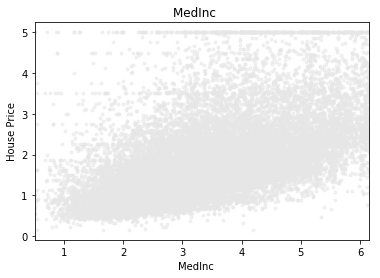

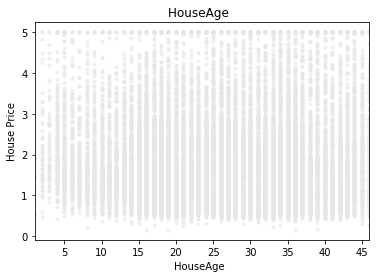

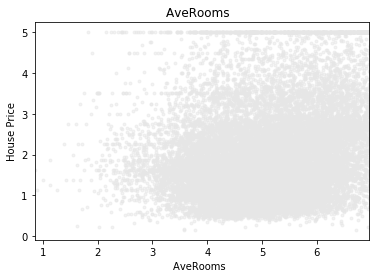

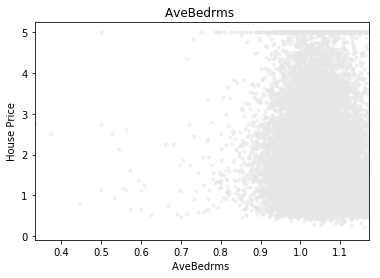

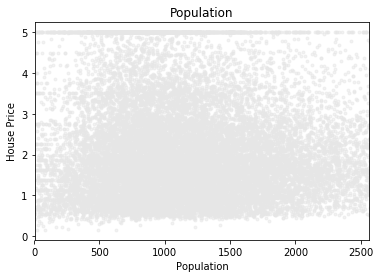

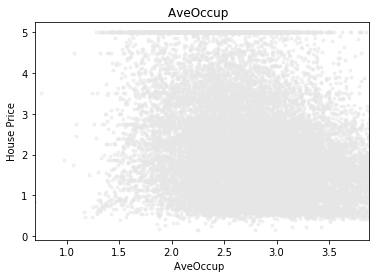

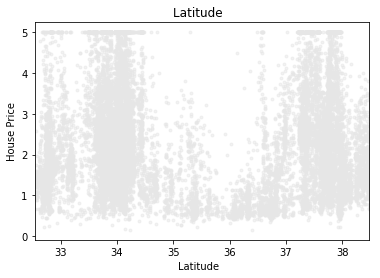

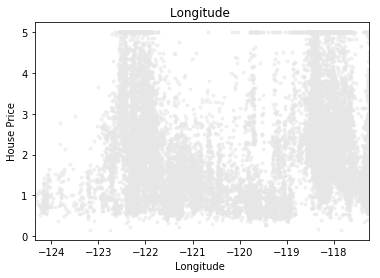

In [10]:
#plot data

for feature in feature_names:
    plt.close("all")
    plt.plot(data[feature], y,'.',alpha=0.5,color=[0.9,0.9,0.9])
    # plot stuff
    plt.title(feature)
    plt.xlim([bins[feature][0],bins[feature][-2]])
    plt.xlabel(feature)
    plt.ylabel('House Price')
    plt.show()

### Plot Results

In [11]:
alphasf = {}
start = 1
for feature in feature_names:
    alphasf[feature] = alphas[start:(start+stumps[feature].shape[1])]
    start = start + stumps[feature].shape[1]
alphasf['mean'] = alphas[0]

In [12]:
def prediction(alphasf, stumps, data, feature):
    prediction= np.zeros(20640)
    for i in range(len(prediction)):
        prediction[i]=alphasf[feature].dot(stumps[feature][i])
        
    return prediction

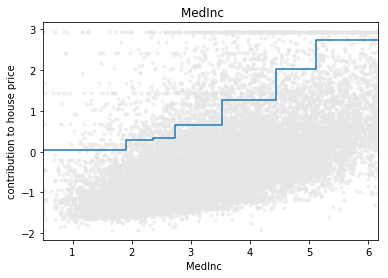

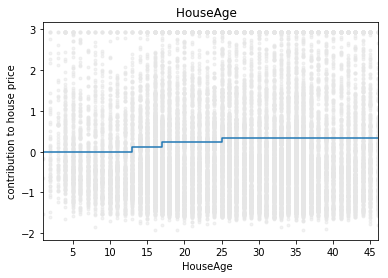

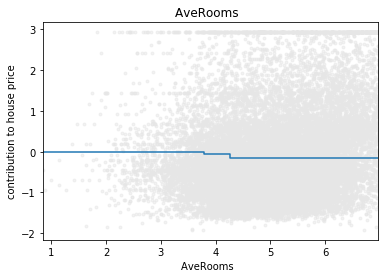

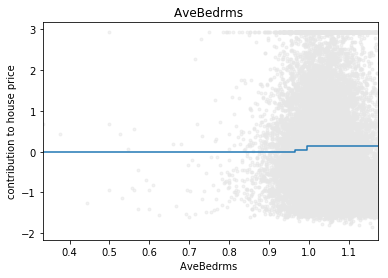

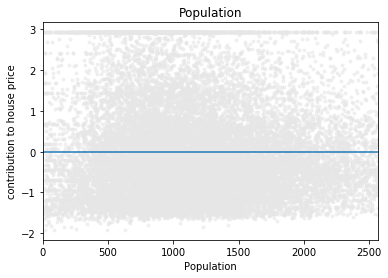

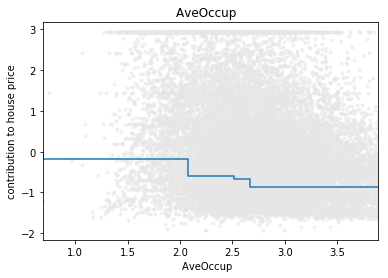

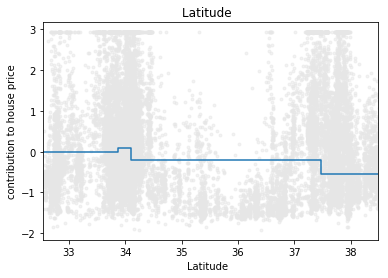

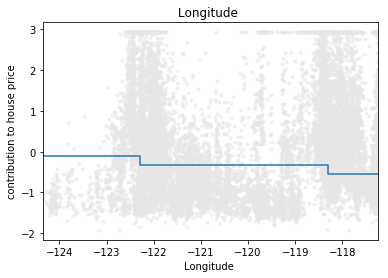

In [24]:
for feature in feature_names:
    plt.close("all")
    plt.plot(data[feature],y-np.mean(y),'.',alpha=0.5,color=[0.9,0.9,0.9])
    #plt.plot(data[feature], prediction(alphasf, stumps, data, feature), '.')
    plt.step(bins[feature][0:10], np.cumsum(alphasf[feature]))
    # plot stuff
    plt.title(feature)
    plt.xlim([bins[feature][0],bins[feature][-2]])
    plt.xlabel(feature)
    plt.ylabel('contribution to house price')
    plt.show()

### part iii

It seems that MedInc follows a strong positive trend. House age and avebedrms also show a weak positive trend. 
Averooms, AveOccup, latitude, and longitude all show weak negative trends. Population shows pretty much no correlation.

### Boosted Decision Trees

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [15]:
clf = GradientBoostingRegressor(loss="ls")
clf.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

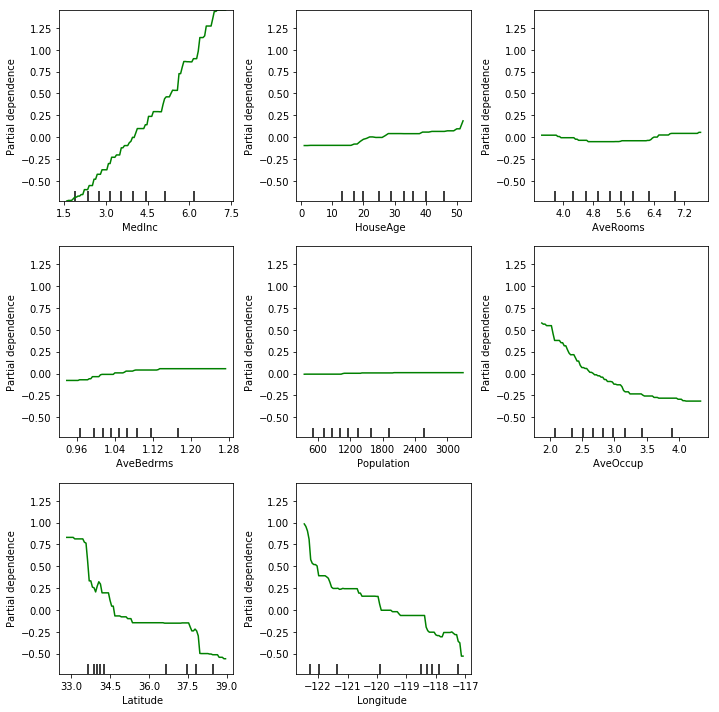

In [16]:
plt.close("all")
plt.figure(figsize=[10,10])
ax = plt.gca()
plot_partial_dependence(clf, X, feature_names, feature_names, n_cols=3, ax=ax) 
plt.tight_layout()
plt.show()

### Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
clf2 = LinearRegression()
clf2.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### Comparison in MSE

In [19]:
np.mean((y-clf2.predict(X))**2)

0.5243209861846071

In [20]:
np.mean((y-clf.predict(X))**2)

0.26188431965892933